# Gaussian Mixture Models

From [In Depth: Gaussian Mixture Models](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

## K-Means clustering - hard assignments

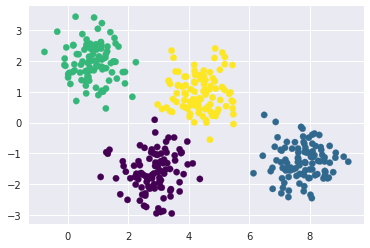

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [13]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

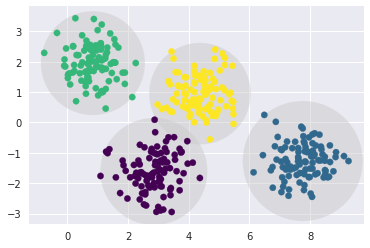

In [14]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

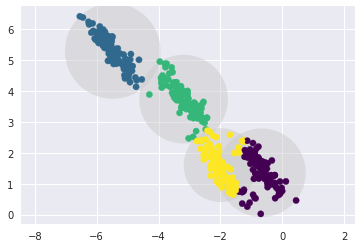

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

## Gaussian Mixture Models - soft assignments

Like with K-means, we can use Gaussian Mixture Models for cluster assignments.

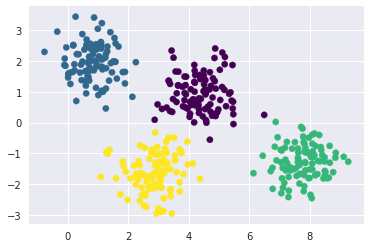

In [16]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

We can obtain the (soft) assignment probabilities using `predict_proba()`, which returns a `n_samples x n_clusters` matrix of assignment probabilities. Here are the first `10` samples:

In [21]:
probs = gmm.predict_proba(X)
print(probs[:10].round(3))

[[0.531 0.    0.469 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.986 0.    0.    0.014]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]]


The following plot renders dot size as a function of confidence; the higher the assignment probability, the larger the dot.

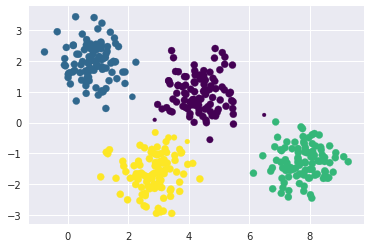

In [22]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [28]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

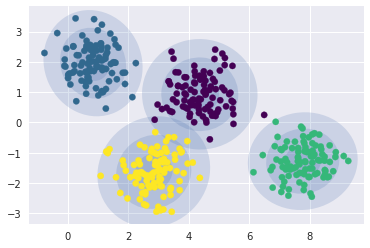

In [29]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

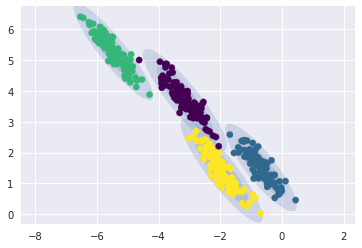

In [33]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

## GMMs for Density Estimation

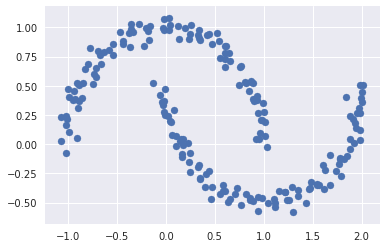

In [34]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Using two gaussians to model this data is not really helpful:

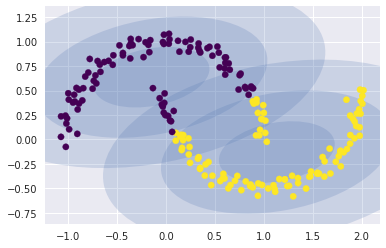

In [35]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Using much more gaussians captures the distribution of the data really well.

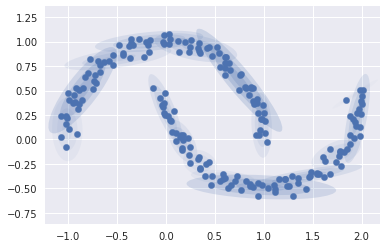

In [38]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Being a generative model, we can now use the GMM to draw new samples from the fitted distribution:

(400, 2) (400,)


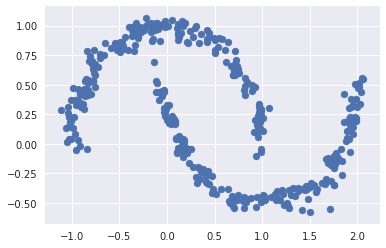

In [49]:
Xnew, Ynew = gmm16.sample(400)
print(Xnew.shape, Ynew.shape)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

## Determining the best number of components

Using the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) or the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) we can compare different models, which allows selecting the model with the best (hyper-)parameters.

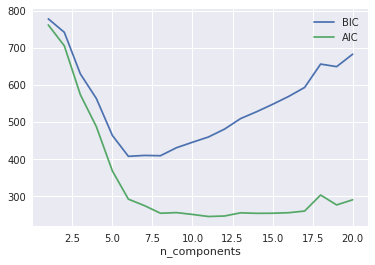

In [51]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

## Generating new data using GMMs

The scikit-learn MNIST dataset consists of 1797 64-dimensional images (size 8x8).

In [53]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

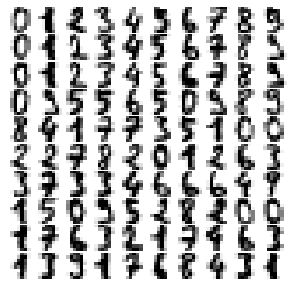

In [64]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(5, 5),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In order to reduce the complexity of the problem (as GMMs suffer from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)) we apply a PCA to reduce the number of dimension. We decide to keep 95% of the variance, which gives us 29 (rather than 64) dimensions.

In [68]:
from sklearn.decomposition import PCA
pca = PCA(0.95, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 29)

We will now select the optimal number of gaussians using the AIC.

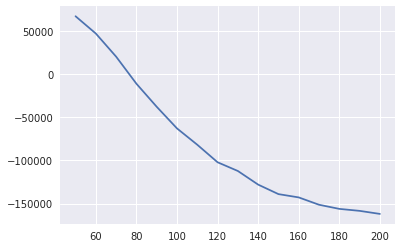

In [69]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [70]:
gmm = GaussianMixture(200, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


The training has converged. We can now sample data, perform the inverse PCA transformation and draw the freshly generated data.

In [71]:
data_new, labels = gmm.sample(100)
data_new.shape

(100, 29)

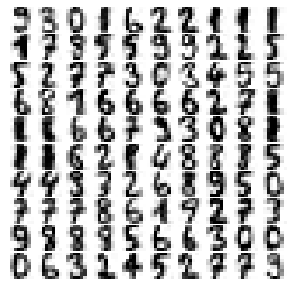

In [72]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

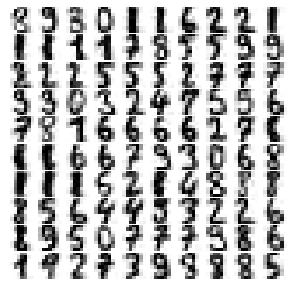

In [77]:
data_new, labels = gmm.sample(121)
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)